# HPGE Gamma Spectroscopy - Spectral Analysis

In [2]:
import numpy as np
import pandas as pd
from scipy import signal
import matplotlib.pyplot as plt
from scipy import stats
from scipy.optimize import curve_fit


In [3]:
#store reference photopeaks as pd.DataFrame
pp_df = pd.read_csv('/PhotoPeak.txt',sep = '[ \s]{2,}|\t',names = ['Photopeak_Energy','Nuclide','BR','Dose']) #photopeak dataframe
pp_df = pp_df.astype({'Photopeak_Energy':float,'Nuclide':str, 'BR':float,'Dose':float})
pp_df['BR'] = pp_df['BR']*0.01 #convert percentage to decimals

def peak_df(filename):
    ''' This function converts the peak data csv into  a pandas dataframe 
       Input: filename - file path of csv
       Output: df2 '''
    df = pd.read_csv(filename,delimiter = ',',header = [0,1]).droplevel(1,axis = 1)
    rename_dict = {' Nuclide':'Nuclide',' Photopeak_Energy':'Photopeak_Energy','      Peak':'Peak_CPS'
    ,' FWHM':'FWHM','  Net_Area':'Net_Area_Count'}
    #dtype_dict = {'Photopeak_Energy':float,'Centroid':float,'Peak_CPS':float,'FWHM':float,'Net_Area_Count':float,''}
    df.rename(columns = rename_dict,inplace = True)
    df2 = df.merge(pp_df,how = 'left' ,on = ['Nuclide','Photopeak_Energy'])  #match BR to peak
    df2['Centroid_err'] = df2['FWHM']/2/np.sqrt(2*np.log(2)*df2['Net_Area_Count'])#Centroid error
    df2['FWHM_err'] = df2['Centroid_err']*np.sqrt(np.log(2))*2 #FWHM error 
    df2['Resolution'] = df2['FWHM']/df2['Centroid']
    df2['Resolution_err']= df2['Resolution']*np.sqrt((df2['Centroid_err']/df2['Centroid'])**2+(df2['FWHM_err']/df2['FWHM'])**2)
    df2['Peak_CPS_BR'] = df2['Peak_CPS']/df2['BR']
    return df2
    
class peak():
    def __init__(self,df):
        self.df = df
    def name(self,name):
        return self.df.loc[self.df.isin({'Nuclide':[name]})]
        


C:\Users\Sergi Kavtaradze\AppData\Local\Temp\ipykernel_15504\4279416536.py:2: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pp_df = pd.read_csv('PhotoPeak.txt',sep = '[ \s]{2,}|\t',names = ['Photopeak_Energy','Nuclide','BR','Dose']) #photopeak dataframe


FileNotFoundError: [Errno 2] No such file or directory: 'PhotoPeak.txt'

In [66]:
path1 = 'Data/Peaks/peaks_Sample1_30_10_23_Mon_09_22.CSV' #peak sample 1
path2 = 'Data/Peaks/peaks_Sample2_31_10_23_14_08.CSV'
path_bg = 'Data/Peaks/peaks_background_17_10_23.csv'
df_1 = peak_df(path1)
df_2 = peak_df(path2)
df_bg= peak_df(path_bg)

In [67]:
def chi2_prob(fit,data,err,df):
    '''This function calculates chi2 probability for given 
       fit array, data array,err and degrees of freedom 
       Inputs: fit  - array of fitted values
               data - array of original data
               err  - error 
               df   - degree of freedom
       Outputs: chi2 probability, 
       the probability of obtaining a value of minimized chi2 
       equal to the fit value or higher, given df'''
    norm_resid = (fit -data)/err #normalized residual
    chi2 = np.sum(norm_resid**2) #chi-square
    chi2_red = chi2/df
    chi2_p = 1-stats.chi2.cdf(chi2,df) #chi2 probability =  1-cumulative distribution function
    print(f' chi2: {chi2} \n reduced chi2: {chi2_red}\n chi2 p-value: {chi2_p}')
    return chi2,chi2_red, chi2_p

Text(0, 0.5, 'Error on FWHM/keV')

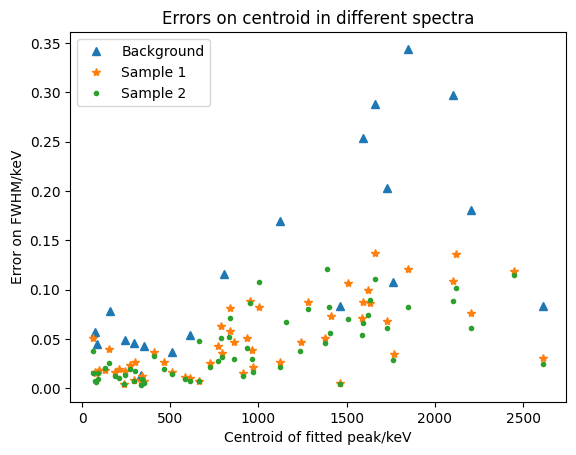

In [107]:

df_list = [df_bg,df_1,df_2]
label_list = ['Background','Sample 1','Sample 2']
marker_list = ['^','*','.']
plt.figure()
plt.title(r'Errors on FWHM in different spectra')
for i in range(3):
    plt.plot(df_list[i]['Centroid'], df_list[i]['FWHM_err'],marker_list[i],label = label_list[i])
plt.legend()
plt.xlabel('Centroid of fitted peak/keV')
plt.ylabel(r'Error on FWHM/keV')
#plt.savefig('centroid_err.pdf')

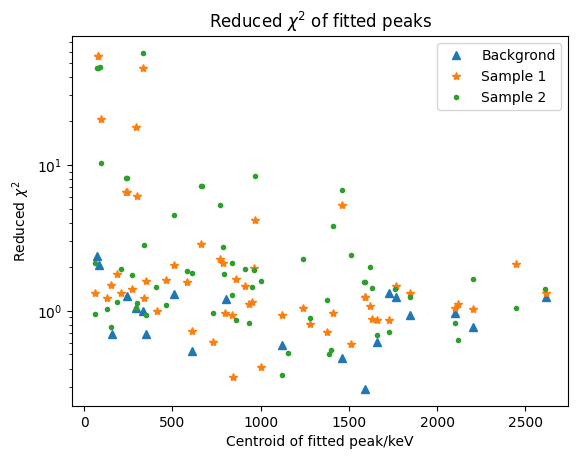

In [89]:
plt.figure()
plt.title(r'Reduced $\chi^2$ of fitted peaks')
plt.plot(df_bg['Centroid'], df_bg['Reduced'],'^',label = 'Backgrond')
plt.plot(df_1['Centroid'], df_1['Reduced'],'*',label = 'Sample 1')
plt.plot(df_2['Centroid'], df_2['Reduced'],'.',label = 'Sample 2')
plt.legend()
plt.yscale('log')
plt.xlabel('Centroid of fitted peak/keV')
plt.ylabel(r'Reduced $\chi^2$')
#plt.savefig('reduced_chi2_gaussian.pdf')


FWHM of Gaussian = $2\sqrt{2\ln{2}}\sigma$, where $\sigma$ is standard deviation. \
Error in centroid of Gaussian can be given by standard error on mean, which is $\sigma/\sqrt{n}$. \
$n$ is the number of samples, i.e. total no. of counts under the peak in this  case

Loading peak data csv into pd.DataFrame

## Energy Calibration

In [68]:
#convert peak energy to channel number (fraction of channel number) using Lynx calibration
#Lynx calibration: energy = grad * channel# + interc
grad = 0.6775230169 #gradient
interc = -0.3439140022 #intercept
energy_to_chan = np.poly1d([1/grad,-interc/grad])


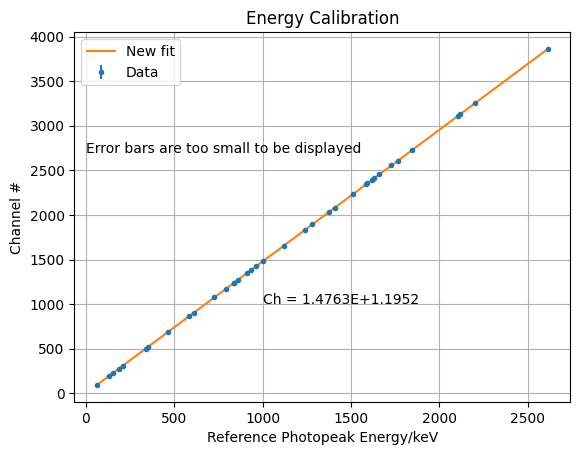

In [181]:
df_new = df_1.dropna(subset = ['Photopeak_Energy']) #drop unidentified peaks
df_new = df_new[df_new['Reduced']<2] #omit peaks with poor fit (reduced chi2 >2 )
x = df_new['Photopeak_Energy']
y = energy_to_chan(df_new['Centroid'])
popt_peak, pcov_peak = np.polyfit(x,y,1,cov = True) #energy callibration using peak
perr_peak = np.sqrt(np.diag(pcov_peak))
peak_fit = np.poly1d(popt_peak)
y_err = 1/grad*df_new['Centroid_err']
#errorbars are too small to be displayed
plt.title('Energy Calibration')
plt.errorbar(x,y,yerr= y_err, fmt = '.',label = 'Data')
plt.plot(x,peak_fit(x),label = 'New fit')
plt.legend()
plt.ylabel('Channel #')
plt.xlabel('Reference Photopeak Energy/keV')
plt.text(1000,1000,f'Ch = {popt_peak[0]:.4f}E+{popt_peak[1]:.4f}')
plt.text(1,2700,'Error bars are too small to be displayed')
plt.grid()
plt.savefig('energy_calibration.pdf')

In [163]:
print(f'Linear fit (energy to channel) using peak energy: E = {popt_peak[0]:.6f}Ch {popt_peak[1]:.6f}')
print(f'Original linear fit (energy to channel) : E = {1/grad:.6f}Ch {-interc/grad:.6f}' )
print('Errors on new fit:')
print(perr_peak)
chi2_prob(peak_fit(x),y,y_err,len(x)-2)
chi2_prob(energy_to_chan(x),y,y_err,len(x)-2)

Linear fit (energy to channel) using peak energy: E = 1.476291Ch 1.195180
Original linear fit (energy to channel) : E = 1.475965Ch 0.507605
Errors on new fit:
[6.75176904e-05 8.74313426e-02]
 chi2: 2781.832628648044 
 reduced chi2: 79.48093224708698
 chi2 p-value: 0.0
 chi2: 57283.31492662872 
 reduced chi2: 1636.6661407608206
 chi2 p-value: 0.0


(57283.31492662872, 1636.6661407608206, 0.0)

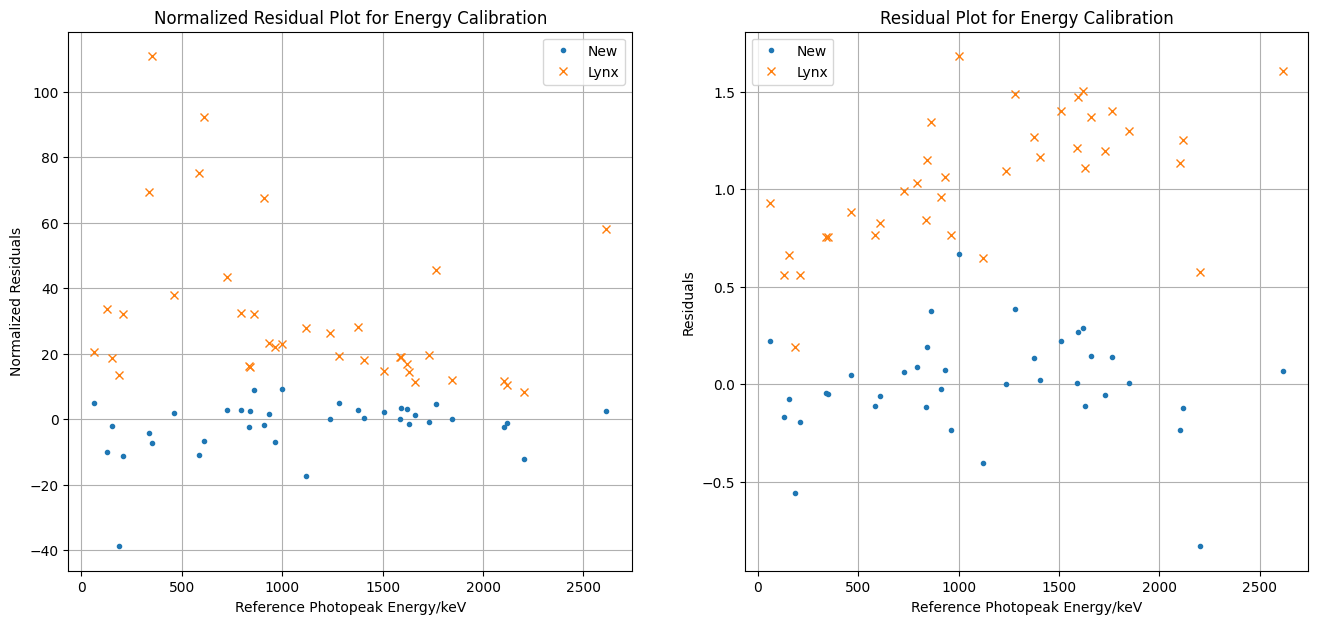

In [182]:
fig,ax = plt.subplots(1,2,figsize = (16,7))
ax[0].set_title('Normalized Residual Plot for Energy Calibration')
ax[0].plot(x,(y-peak_fit(x))/y_err,'.',label= 'New')
ax[0].plot(x,(y-energy_to_chan(x))/y_err,'x',label = 'Lynx')
ax[0].set_xlabel('Reference Photopeak Energy/keV')
ax[0].set_ylabel('Normalized Residuals')
ax[0].grid()
ax[0].legend()
ax[1].set_title('Residual Plot for Energy Calibration')
ax[1].plot(x,(y-peak_fit(x)),'.',label= 'New')
ax[1].plot(x,(y-energy_to_chan(x)),'x',label = 'Lynx')
ax[1].set_xlabel('Reference Photopeak Energy/keV')
ax[1].set_ylabel('Residuals')
ax[1].grid()
ax[1].legend()
plt.savefig('energy_norm_resid.pdf')

In [72]:
chi2_prob(y,peak_fit(x),y_err,len(x)-2)

 chi2: 2781.832628648044 
 reduced chi2: 79.48093224708698
 chi2 p-value: 0.0


(2781.832628648044, 79.48093224708698, 0.0)

## Resolution Calibration

Resolution = $\frac{FWHM}{E_0}$,
where $FWHM = \sqrt{a \times E_0+b}$, a

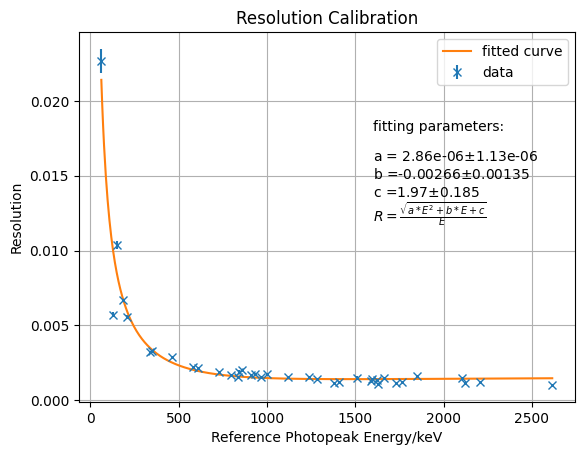

In [184]:
def res_fit(peak_energy,a,b):
    '''This function is used for fitting resolution as a function of energy
       res = np.sqrt(a*energy+b)/energy
       Input:  peak_energy - reference photopeak energy
               a,b         - parameters for the above formula
       Output: resolution
       '''
    return np.sqrt(a*peak_energy+b)/peak_energy

def res_fit_2(peak_energy,a,b,c):
    '''This function is used for fitting resolution as a function of energy
       res = np.sqrt(a*energy+b)/energy
       Input:  peak_energy - reference photopeak energy
               a,b         - parameters for the above formula
       Output: resolution
       '''
    return np.sqrt(a*peak_energy**2+b*peak_energy+c)/peak_energy

x_res = df_new['Photopeak_Energy']
y_res = df_new['Resolution']
y_err_res = df_new['Resolution_err']
res_par, res_cov = curve_fit(res_fit_2,x_res,y_res, p0 = [0.00001,0.00055, 1.8])
res_fit_err = np.sqrt(np.diag(res_cov))
x_plot = np.linspace(min(x_res),max(x_res),500)

plt.figure()
plt.title('Resolution Calibration')
plt.errorbar(x_res,y_res,yerr = y_err_res,fmt = 'x',label = 'data')
plt.plot(x_plot,res_fit_2(x_plot,*res_par), label = 'fitted curve')
plt.ylabel('Resolution')
plt.xlabel('Reference Photopeak Energy/keV')
plt.legend()
plt.text(1600,0.018,f'fitting parameters:')
plt.text(1600,0.016,f'a = {res_par[0]:.3g}' + r'$\pm$'+ f'{res_fit_err[0]:.3g}')
plt.text(1600,0.0148,f'b ={res_par[1]:.3g}' + r'$\pm$'+ f'{res_fit_err[1]:.3g}')
plt.text(1600,0.0136,f'c ={res_par[2]:.3g}' + r'$\pm$'+ f'{res_fit_err[2]:.3g}')
plt.text(1600,0.012,r'$R = \frac{\sqrt{a * E^2+b*E+c}}{E}$')
plt.grid()
plt.savefig('res_calibration.pdf')

In [169]:
print(res_par)
print(res_fit_err)

[ 2.86239474e-06 -2.66498393e-03  1.96773455e+00]
[1.13197603e-06 1.34651540e-03 1.84970389e-01]


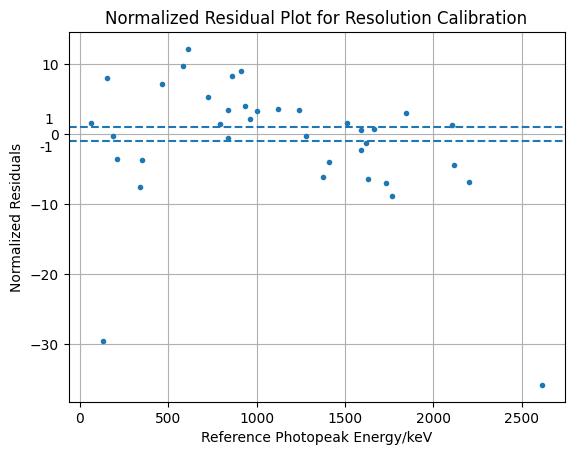

In [185]:
plt.figure()
plt.title('Normalized Residual Plot for Resolution Calibration')
plt.plot(x_res,(y_res-res_fit_2(x_res,*res_par))/y_err_res,'.')
plt.xlabel('Reference Photopeak Energy/keV')
plt.ylabel('Normalized Residuals')
plt.grid()
plt.axhline(1,linestyle = '--')
plt.axhline(-1,linestyle = '--')
plt.text(-150, 1, '1', ha='right', va='bottom')
plt.text(-150, -1, '-1', ha='right', va='top')
plt.savefig('res_norm_resid.pdf')

In [173]:
chi2_prob(y_res,res_fit_2(x_res,*res_par),y_err_res,len(x_res)-2)

 chi2: 3152.7349824756625 
 reduced chi2: 90.0781423564475
 chi2 p-value: 0.0


(3152.7349824756625, 90.0781423564475, 0.0)

In [76]:
df_new['Nuclide'].unique()

array(['Th234', 'Ac228', 'Ra226', 'Pb214', 'Tl208', 'Bi214', 'Bi212',
       'Pa234m', 'Tl208 (D.E.)', 'Tl208 (S.E.)'], dtype=object)

### Plots of counts / branching ratio of nuclides at different energies

In [77]:
df = df_new
df = df[df['Nuclide']=='Bi212']
#plt.plot(df['Photopeak_Energy'],df['Peak_CPS_BR'])
df['BR']

22   NaN
44   NaN
Name: BR, dtype: float64

In [92]:
df_2[df_2['Nuclide']=='Bi212'][['Centroid','Photopeak_Energy']]

,Centroid,Photopeak_Energy
25,727.40,727.33
50,1620.76,1620.50


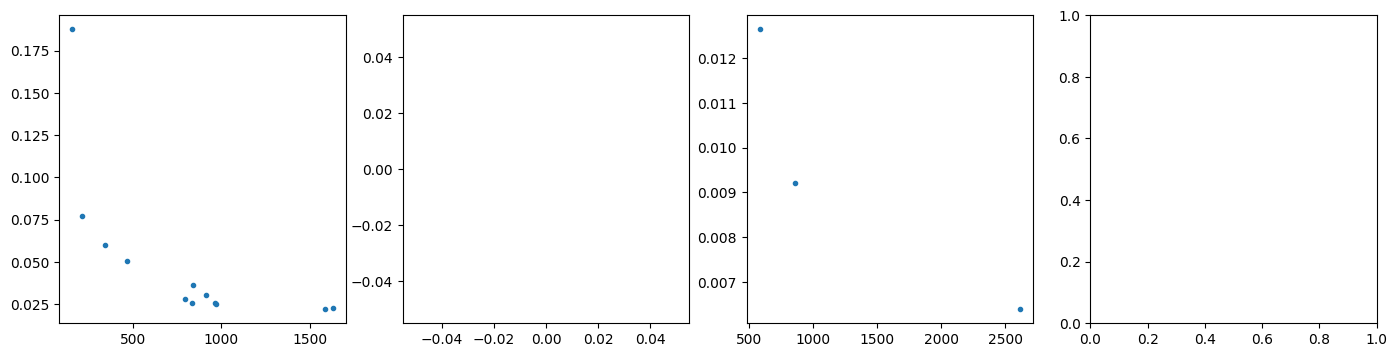

In [78]:
U238_chain = ['Th234','Pa234m','Ra226','Pb214','Bi214']
Th232_chain = ['Ac228','Bi212','Tl208']
def rel_activity(df0,chain):
        fig,ax = plt.subplots(1,4,figsize = (17,4))
        i = 0
        for nuclide in chain:
                df = df0[df0['Nuclide']==nuclide].dropna(subset = 'Peak_CPS_BR')
                ax[i].plot(df['Photopeak_Energy'],df['Peak_CPS_BR'],'.')
                i +=1
        plt.show()
        
rel_activity(df_1,Th232_chain)

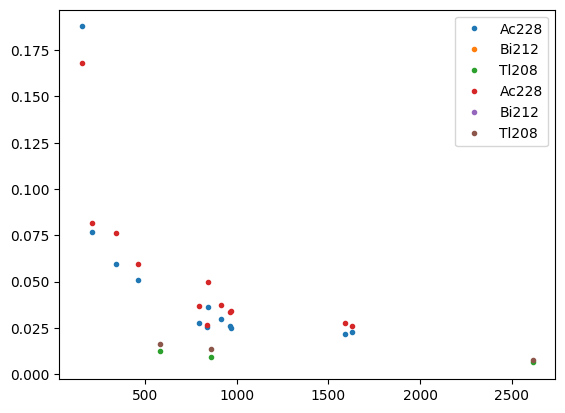

In [96]:
plt.figure()
i = 0

for nuclide in Th232_chain:
    df = df_1[df_1['Nuclide']==nuclide].dropna(subset = 'Peak_CPS_BR')
    plt.plot(df['Photopeak_Energy'],df['Peak_CPS_BR'],'.',label = nuclide )
    i +=1
    plt.legend()
for nuclide in Th232_chain:
    df = df_2[df_2['Nuclide']==nuclide].dropna(subset = 'Peak_CPS_BR')
    plt.plot(df['Photopeak_Energy'],df['Peak_CPS_BR'],'.',label = nuclide )
    i +=1
    plt.legend()
    


In [156]:
diff = df_1['Centroid'][1:].to_numpy()-df_1['Centroid'][:-1].to_numpy()
df_1[:-1][diff<3*df_1['FWHM'][:-1].to_numpy()]['Reduced']

1     56.12
32     1.97
42     1.23
Name: Reduced, dtype: float64

In [177]:
def compton_edge(energy):
    ratio = energy/511 #energy to electron rest energy  ratio
    return energy*(2*ratio/(2*ratio+1))
compton_edge(1460.75)
compton_edge(2614.53)

2381.7754939495408